In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import linear_model

%matplotlib inline

In [100]:
df = pd.read_csv('airline-passengers.csv', index_col='Month', parse_dates=['Month'])

In [101]:
df['trend'] = df['Passengers'].ewm(halflife=12).mean()
df['detrended'] = df['Passengers'] / df['trend']
df_seasonality = df['detrended'].groupby(df.index.month).mean().rename('seasonality')
df = df.join(df_seasonality, how='left', on=df.index.month)

In [110]:
df['preprocessed'] = df['detrended'] - df['seasonality']
df['prediction_raw'] = df['preprocessed'].mean()


In [111]:
training_size=int(len(df)*0.65)
test_size=len(df)-training_size
train_data,test_data=df[:training_size],df[training_size:len(df)]


## Approach 1: Prediction by the global mean

/var/folders/zf/z_5ht60d3n7gfsmz14cjq6fc0000gn/T/ipykernel_62152/102898768.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['prediction_raw'] = train_data['preprocessed'].mean()


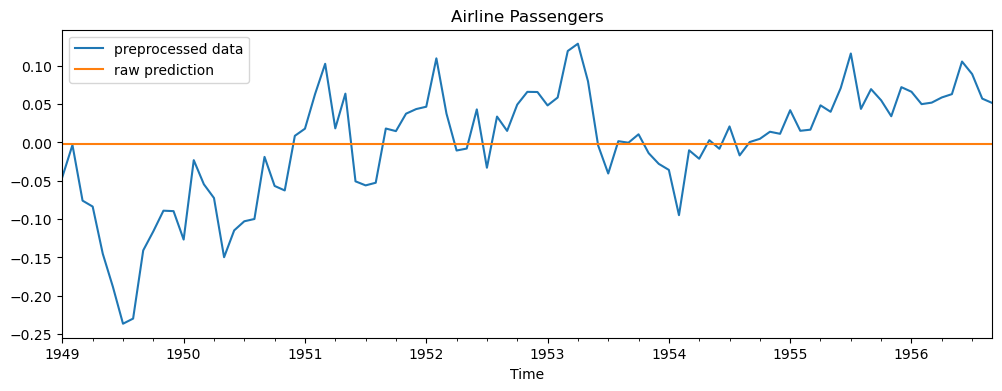

In [112]:
train_data['prediction_raw'] = train_data['preprocessed'].mean()

plt.figure(figsize=(12,4))
train_data['preprocessed'].plot(label='preprocessed data')
train_data['prediction_raw'].plot(label='raw prediction')
plt.xlabel('Time')
plt.ylabel('')
plt.title('Airline Passengers')
plt.legend(loc='upper left')
plt.show()


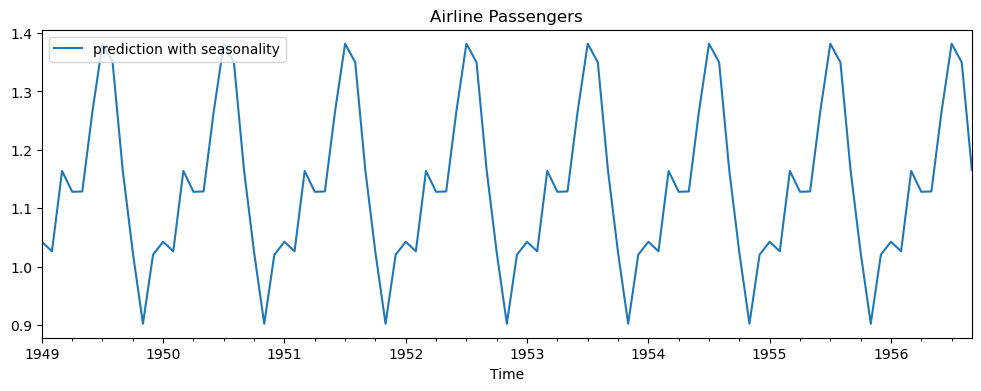

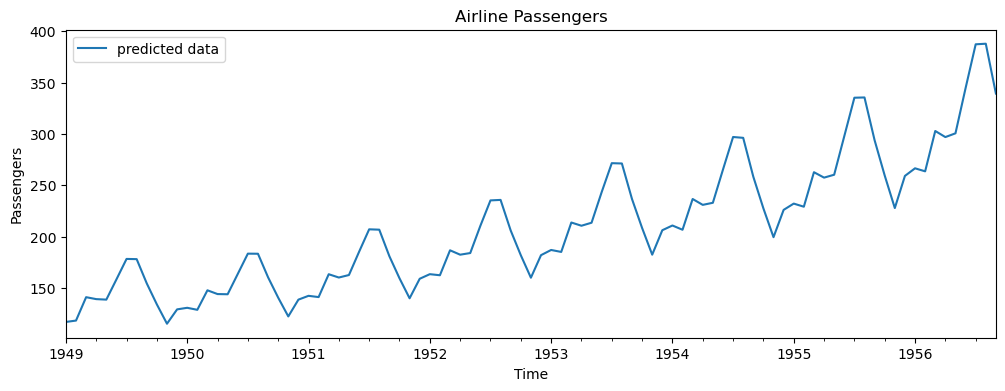

/var/folders/zf/z_5ht60d3n7gfsmz14cjq6fc0000gn/T/ipykernel_62152/1959893535.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['prediction'] = (test_data['prediction_raw'] + test_data['seasonality']) * test_data['trend']


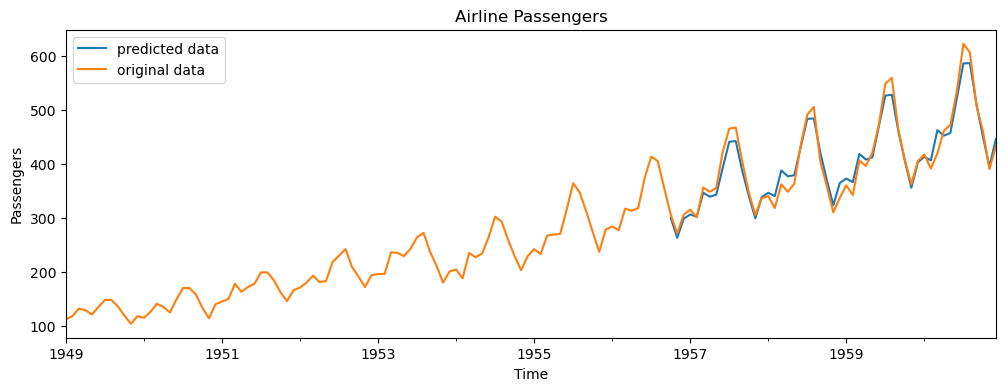

In [113]:
plt.figure(figsize=(12,4))
(train_data['prediction_raw'] + train_data['seasonality']).plot(label='prediction with seasonality')
plt.xlabel('Time')
plt.ylabel('')
plt.title('Airline Passengers')
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(12,4))
((train_data['prediction_raw'] + train_data['seasonality']) * train_data['trend']).plot(label='predicted data')
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.title('Airline Passengers')
plt.legend(loc='upper left')
plt.show()

test_data['prediction'] = (test_data['prediction_raw'] + test_data['seasonality']) * test_data['trend']

plt.figure(figsize=(12,4))
test_data['prediction'].plot(label='predicted data')
df['Passengers'].plot(label='original data')
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.title('Airline Passengers')
plt.legend(loc='upper left')
plt.show()

In [114]:
print('MSE: %0.4f' % ((df['Passengers'] - test_data['prediction'])**2).mean())
print('MAE: %0.4f' % (df['Passengers'] - test_data['prediction']).abs().mean())
print('MAPE: %0.4f' % ((df['Passengers'] - test_data['prediction']) / df['Passengers']).abs().mean())


MSE: 282.7345
MAE: 13.7086
MAPE: 0.0336


## Approach 2: Prediction by the previous value


/var/folders/zf/z_5ht60d3n7gfsmz14cjq6fc0000gn/T/ipykernel_62152/3135884052.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['prediction_raw'] = test_data['preprocessed'].shift(1).fillna(0.0)


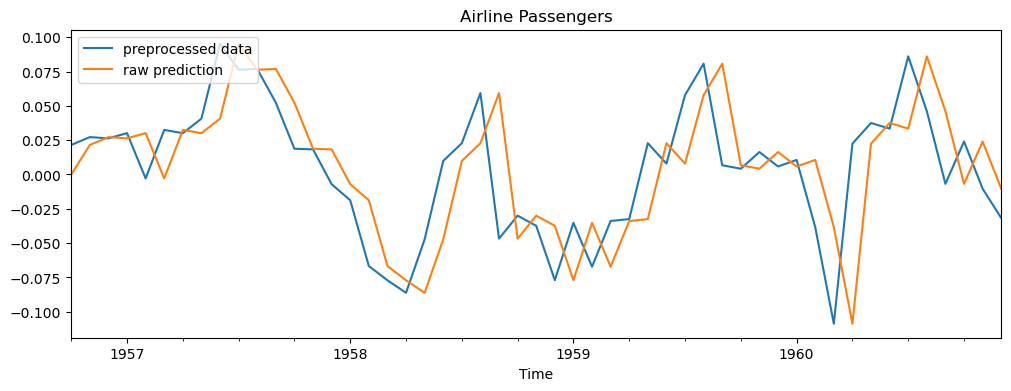

In [115]:
test_data['prediction_raw'] = test_data['preprocessed'].shift(1).fillna(0.0)

plt.figure(figsize=(12,4))
test_data['preprocessed'].plot(label='preprocessed data')
test_data['prediction_raw'].plot(label='raw prediction')
plt.xlabel('Time')
plt.ylabel('')
plt.title('Airline Passengers')
plt.legend(loc='upper left')
plt.show()

/var/folders/zf/z_5ht60d3n7gfsmz14cjq6fc0000gn/T/ipykernel_62152/2863166564.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['prediction'] = (test_data['prediction_raw'] + test_data['seasonality']) * test_data['trend']


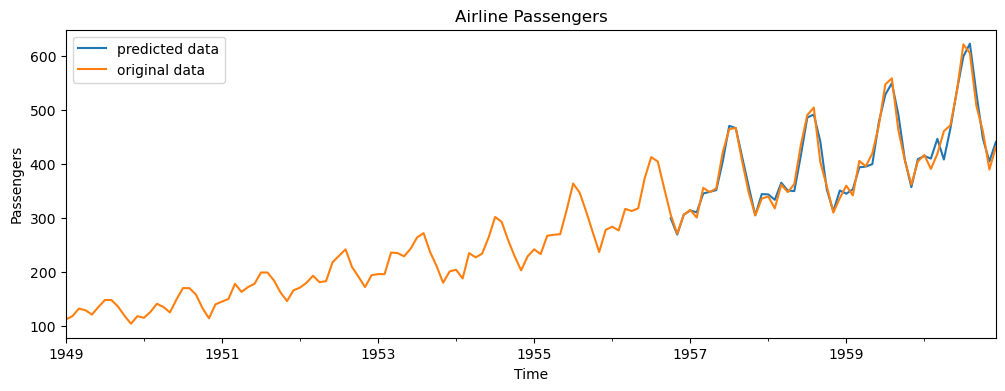

MSE: 227.3839
MAE: 11.0347
MAPE: 0.0264


In [116]:
test_data['prediction'] = (test_data['prediction_raw'] + test_data['seasonality']) * test_data['trend']

plt.figure(figsize=(12,4))
test_data['prediction'].plot(label='predicted data')
df['Passengers'].plot(label='original data')
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.title('Airline Passengers')
plt.legend(loc='upper left')
plt.show()

print('MSE: %0.4f' % ((df['Passengers'] - test_data['prediction'])**2).mean())
print('MAE: %0.4f' % (df['Passengers'] - test_data['prediction']).abs().mean())
print('MAPE: %0.4f' % ((df['Passengers'] - test_data['prediction']) / df['Passengers']).abs().mean())

## Approach 3: Prediction by the moving average


/var/folders/zf/z_5ht60d3n7gfsmz14cjq6fc0000gn/T/ipykernel_62152/4281737397.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['prediction_raw'] = df['preprocessed'].shift(1).fillna(0.0).rolling(window=3, min_periods=1).mean()


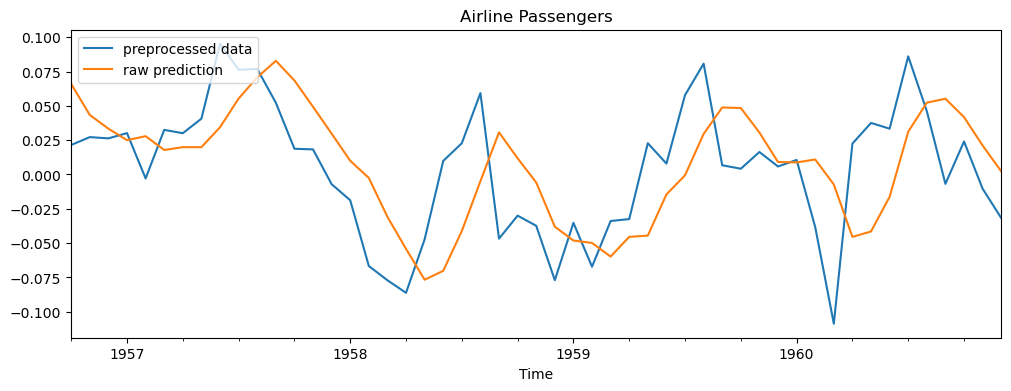

In [117]:
test_data['prediction_raw'] = df['preprocessed'].shift(1).fillna(0.0).rolling(window=3, min_periods=1).mean()
# df['prediction_raw'] = df['preprocessed'].shift(1).fillna(0.0).rolling(window=12, min_periods=1).mean()

plt.figure(figsize=(12,4))
test_data['preprocessed'].plot(label='preprocessed data')
test_data['prediction_raw'].plot(label='raw prediction')
plt.xlabel('Time')
plt.ylabel('')
plt.title('Airline Passengers')
plt.legend(loc='upper left')
plt.show()

/var/folders/zf/z_5ht60d3n7gfsmz14cjq6fc0000gn/T/ipykernel_62152/2863166564.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['prediction'] = (test_data['prediction_raw'] + test_data['seasonality']) * test_data['trend']


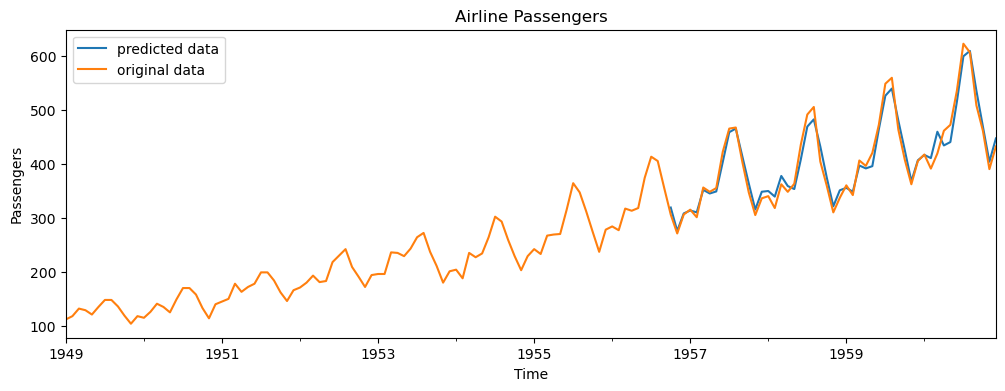

MSE: 268.7919
MAE: 13.6742
MAPE: 0.0332


In [118]:
test_data['prediction'] = (test_data['prediction_raw'] + test_data['seasonality']) * test_data['trend']

plt.figure(figsize=(12,4))
test_data['prediction'].plot(label='predicted data')
df['Passengers'].plot(label='original data')
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.title('Airline Passengers')
plt.legend(loc='upper left')
plt.show()

print('MSE: %0.4f' % ((df['Passengers'] - test_data['prediction'])**2).mean())
print('MAE: %0.4f' % (df['Passengers'] - test_data['prediction']).abs().mean())
print('MAPE: %0.4f' % ((df['Passengers'] - test_data['prediction']) / df['Passengers']).abs().mean())

## Approach 4: Prediction by the linear regression

In [130]:
df_r = df.copy()
df_r['detrended'] = df_r['Passengers'] / df_r['trend']
df_r['detrended_sub'] = df_r['Passengers'] - df_r['trend']

df_r_seasonality = df_r['detrended'].groupby(df_r.index.month).mean().rename('df_r_seasonality')
# df_r_seasonality = df_r['detrended_sub'].groupby(df_r.index.month).mean().rename('df_r_seasonality')


In [120]:
df_r = df_r.join(df_r_seasonality, how='left', on=df_r.index.month)

In [148]:
# df_r['preprocessed'] = df_r['detrended'] - df_r['seasonality']
# subtracting the trend
# df_r['preprocessed'] = df_r['detrended_sub'] - df_r['seasonality']
# dividing the detrended data by the seasonality
df_r['preprocessed'] = df_r['detrended'] / df_r['seasonality']

In [149]:
reg = linear_model.LinearRegression()

X = df_r['preprocessed'].shift(1).values[1:].reshape(-1, 1)
y = df_r['preprocessed'].values[1:]

reg.fit(X, y)

y_predicted = np.zeros(len(df_r))
y_predicted[1:] = reg.predict(X)

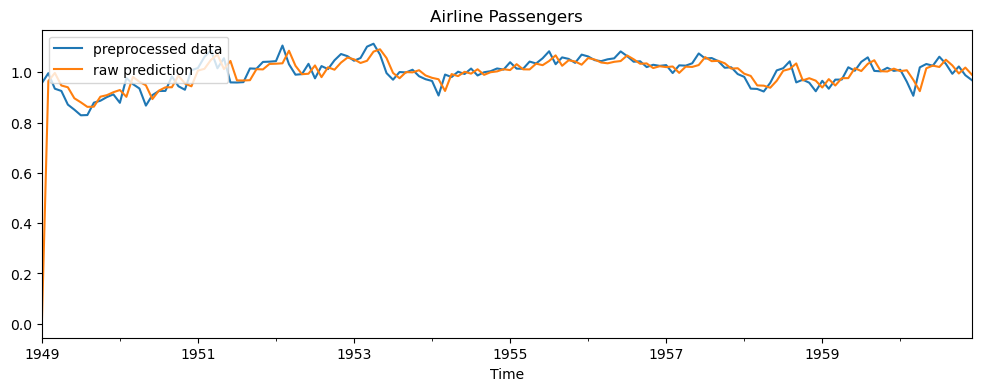

In [150]:
df_r['prediction_raw'] = y_predicted

plt.figure(figsize=(12,4))
df_r['preprocessed'].plot(label='preprocessed data')
df_r['prediction_raw'].plot(label='raw prediction')
plt.xlabel('Time')
plt.ylabel('')
plt.title('Airline Passengers')
plt.legend(loc='upper left')
plt.show()

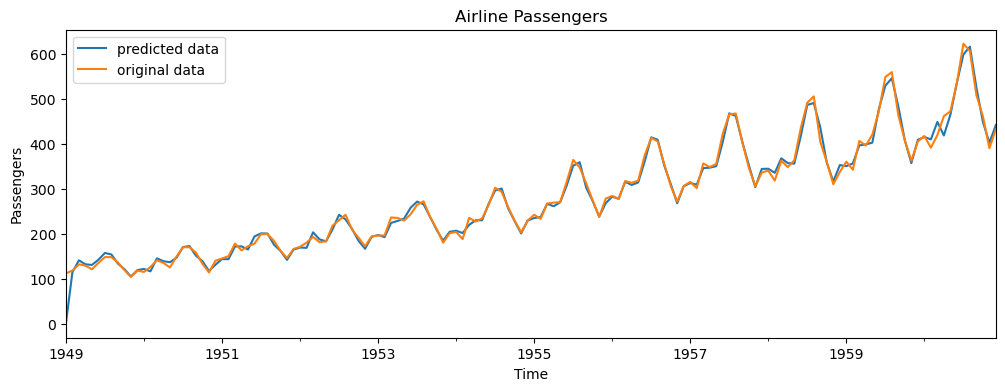

MSE: 179.9619
MAE: 7.8175
MAPE: 0.0334


In [151]:
# df_r['prediction'] = (df_r['prediction_raw'] + df_r['seasonality']) * df_r['trend']
# subtracting the trend
# df_r['prediction'] = (df_r['prediction_raw'] + df_r['seasonality']) + df_r['trend']
# dividing the detrended data by the seasonality
df_r['prediction'] = (df_r['prediction_raw'] * df_r['seasonality']) * df_r['trend']

plt.figure(figsize=(12,4))
df_r['prediction'].plot(label='predicted data')
df_r['Passengers'].plot(label='original data')
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.title('Airline Passengers')
plt.legend(loc='upper left')
plt.show()

print('MSE: %0.4f' % ((df_r['Passengers'] - df_r['prediction'])**2).mean())
print('MAE: %0.4f' % (df_r['Passengers'] - df_r['prediction']).abs().mean())
print('MAPE: %0.4f' % ((df_r['Passengers'] - df_r['prediction']) / df_r['Passengers']).abs().mean())